In [2]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (warning)
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
# 학습 or 실행 도중 오류가 나서 session이 안닫혔을 경우
# tf.reset_default_graph ()

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58892288/58889256 [==============================] - 22s 0us/step


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [9]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i *batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모드 ㄴ이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [14]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['acc'])


history = model.fit(train_features, train_labels,
                   epochs = 30,
                   batch_size = 20, 
                   validation_data = (validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 664us/step - loss: 0.5845 - acc: 0.6690 - val_loss: 0.4305 - val_acc: 0.8320
Epoch 2/30
2000/2000 [==============================] - 1s 383us/step - loss: 0.4349 - acc: 0.7975 - val_loss: 0.3635 - val_acc: 0.8560
Epoch 3/30
2000/2000 [==============================] - 1s 383us/step - loss: 0.3591 - acc: 0.8460 - val_loss: 0.3240 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 1s 384us/step - loss: 0.3164 - acc: 0.8715 - val_loss: 0.2981 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 1s 396us/step - loss: 0.2814 - acc: 0.8905 - val_loss: 0.2815 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 1s 385us/step - loss: 0.2627 - acc: 0.8980 - val_loss: 0.2715 - val_acc: 0.8930
Epoch 7/30
2000/2000 [==============================] - 1s 386us/step - loss: 0.2540 - acc: 0.9010 - val_loss: 0.2641 - val_acc: 0.8920


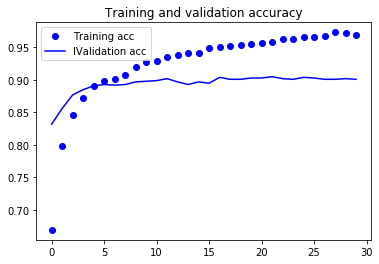

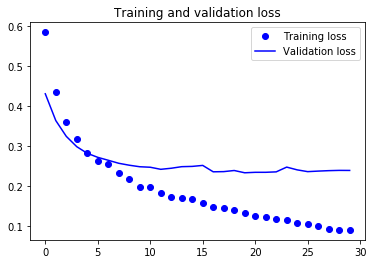

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'lValidation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [21]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수 : ',
     len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수 :  30


In [22]:
conv_base.trainable = False

In [23]:
print('conv_base를 동결한 후 훈련되는 가중치의 수 : ',
     len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수 :  4


In [26]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest')

# 검증 데이터는 증식되어서는 안됩니다.
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    # 타깃 디렉터리
    train_dir,
    # 모든 이미지의 크기를 150x150로 변경합니다
    target_size = (150, 150),
    batch_size = 20,
    # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
             optimizer = optimizers.RMSprop(lr = 2e-5),
             metrics = ['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50,
    verbose = 2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 23s - loss: 0.5443 - acc: 0.7495 - val_loss: 0.4197 - val_acc: 0.8430
Epoch 2/30
 - 23s - loss: 0.4020 - acc: 0.8390 - val_loss: 0.3400 - val_acc: 0.8670
Epoch 3/30
 - 24s - loss: 0.3472 - acc: 0.8530 - val_loss: 0.3077 - val_acc: 0.8770
Epoch 4/30
 - 25s - loss: 0.3227 - acc: 0.8665 - val_loss: 0.2877 - val_acc: 0.8870
Epoch 5/30
 - 26s - loss: 0.3003 - acc: 0.8795 - val_loss: 0.2843 - val_acc: 0.8840
Epoch 6/30
 - 28s - loss: 0.2911 - acc: 0.8885 - val_loss: 0.2641 - val_acc: 0.8930
Epoch 7/30
 - 28s - loss: 0.2770 - acc: 0.8935 - val_loss: 0.2572 - val_acc: 0.8960
Epoch 8/30
 - 30s - loss: 0.2625 - acc: 0.9015 - val_loss: 0.2524 - val_acc: 0.8950
Epoch 9/30
 - 30s - loss: 0.2542 - acc: 0.9035 - val_loss: 0.2540 - val_acc: 0.8960
Epoch 10/30
 - 30s - loss: 0.2527 - acc: 0.8920 - val_loss: 0.2435 - val_acc: 0.9000
Epoch 11/30
 - 30s - loss: 0.2451 - acc: 0.9020 - val_loss: 0.2495 - val_ac

In [27]:
model.save('cats_and_dogs_small_3.h5')

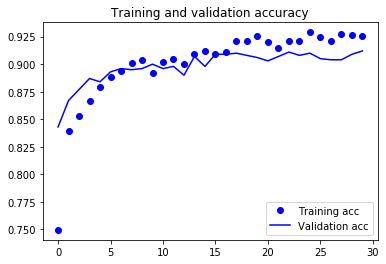

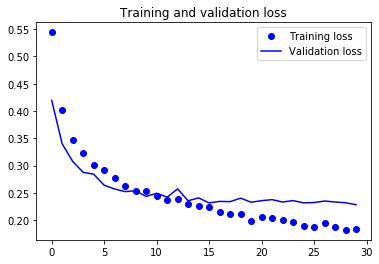

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

미세 조정

In [29]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [30]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [31]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s 277ms/step - loss: 0.1867 - acc: 0.9260 - val_loss: 0.2500 - val_acc: 0.9060
Epoch 2/100
100/100 [==============================] - 27s 271ms/step - loss: 0.1538 - acc: 0.9405 - val_loss: 0.2292 - val_acc: 0.9140
Epoch 3/100
100/100 [==============================] - 29s 286ms/step - loss: 0.1441 - acc: 0.9405 - val_loss: 0.2091 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 30s 300ms/step - loss: 0.1286 - acc: 0.9455 - val_loss: 0.2211 - val_acc: 0.9120
Epoch 5/100
100/100 [==============================] - 31s 307ms/step - loss: 0.1004 - acc: 0.9625 - val_loss: 0.2301 - val_acc: 0.9200
Epoch 6/100
100/100 [==============================] - 32s 317ms/step - loss: 0.0991 - acc: 0.9595 - val_loss: 0.1913 - val_acc: 0.9310
Epoch 7/100
100/100 [==============================] - 32s 324ms/step - loss: 0.0854 - acc: 0.9705 - val_loss: 0.2040 - val_acc: 0.9300
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 52s 523ms/step - loss: 0.0044 - acc: 0.9980 - val_loss: 0.3410 - val_acc: 0.9300
Epoch 62/100
100/100 [==============================] - 53s 525ms/step - loss: 0.0059 - acc: 0.9985 - val_loss: 0.3796 - val_acc: 0.9270
Epoch 63/100
100/100 [==============================] - 52s 524ms/step - loss: 9.3770e-04 - acc: 1.0000 - val_loss: 0.3501 - val_acc: 0.9410
Epoch 64/100
100/100 [==============================] - 53s 532ms/step - loss: 0.0082 - acc: 0.9985 - val_loss: 0.3198 - val_acc: 0.9340
Epoch 65/100
100/100 [==============================] - 53s 526ms/step - loss: 0.0064 - acc: 0.9980 - val_loss: 0.3425 - val_acc: 0.9280
Epoch 66/100
100/100 [==============================] - 52s 523ms/step - loss: 0.0059 - acc: 0.9980 - val_loss: 0.3162 - val_acc: 0.9380
Epoch 67/100
100/100 [==============================] - 52s 525ms/step - loss: 0.0018 - acc: 0.9990 - val_loss: 0.3818 - val_acc: 0.9240
Epoch 68/100
100/100 [===============

In [32]:
model.save('cats_and_dogs_small_4.h5')

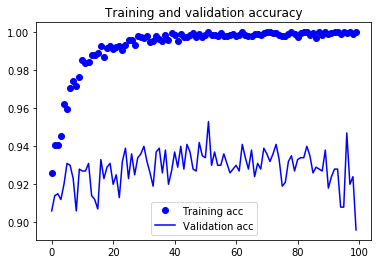

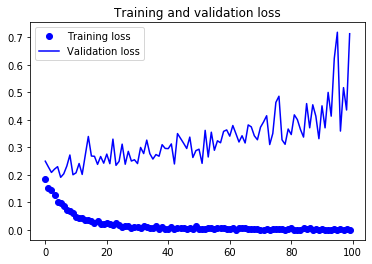

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

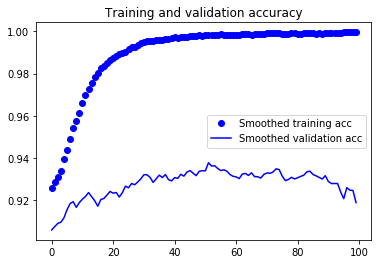

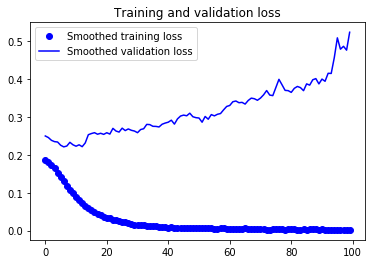

In [34]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.920999995470047


# 수행평가 ( fresh and rotten)

In [8]:
import os, shutil
import numpy as np
np.random.seed(777)

In [ ]:
file_size = []
file_size.append(len(listdir))
min(file_size) 로 작읍값에 맞추거나
큰값으로 generator 돌리기

In [4]:
# 튜닝 시 디렉터리 경로 실행 해주기
base_dir = './dataset/dataset/CNN'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_freshapple_dir = os.path.join(train_dir, 'freshapples')
train_freshbanana_dir = os.path.join(train_dir, 'freshbanana')
train_freshorange_dir = os.path.join(train_dir, 'freshoranges')
train_rottenapple_dir = os.path.join(train_dir, 'rottenapples')
train_rottenbanana_dir = os.path.join(train_dir, 'rottenbanana')
train_rottenorange_dir = os.path.join(train_dir, 'rottenoranges')

validation_freshapple_dir = os.path.join(validation_dir, 'freshapples')
validation_freshbanana_dir = os.path.join(validation_dir, 'freshbanana')
validation_freshorange_dir = os.path.join(validation_dir, 'freshoranges')
validation_rottenapple_dir = os.path.join(validation_dir, 'rottenapples')
validation_rottenbanana_dir = os.path.join(validation_dir, 'rottenbanana')
validation_rottenorange_dir = os.path.join(validation_dir, 'rottenoranges')

test_freshapple_dir = os.path.join(test_dir, 'freshapples')
test_freshbanana_dir = os.path.join(test_dir, 'freshbanana')
test_freshorange_dir = os.path.join(test_dir, 'freshoranges')
test_rottenapple_dir = os.path.join(test_dir, 'rottenapples')
test_rottenbanana_dir = os.path.join(test_dir, 'rottenbanana')
test_rottenorange_dir = os.path.join(test_dir, 'rottenoranges')

In [19]:

# original_dataset_dir = './datasets/datasets'
np.random.seed(777)

base_dir = './dataset/dataset/CNN'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)



train_freshapple_dir = os.path.join(train_dir, 'freshapples')
os.mkdir(train_freshapple_dir)

train_freshbanana_dir = os.path.join(train_dir, 'freshbanana')
os.mkdir(train_freshbanana_dir)

train_freshorange_dir = os.path.join(train_dir, 'freshoranges')
os.mkdir(train_freshorange_dir)

train_rottenapple_dir = os.path.join(train_dir, 'rottenapples')
os.mkdir(train_rottenapple_dir)

train_rottenbanana_dir = os.path.join(train_dir, 'rottenbanana')
os.mkdir(train_rottenbanana_dir)

train_rottenorange_dir = os.path.join(train_dir, 'rottenoranges')
os.mkdir(train_rottenorange_dir)


validation_freshapple_dir = os.path.join(validation_dir, 'freshapples')
os.mkdir(validation_freshapple_dir)

validation_freshbanana_dir = os.path.join(validation_dir, 'freshbanana')
os.mkdir(validation_freshbanana_dir)

validation_freshorange_dir = os.path.join(validation_dir, 'freshoranges')
os.mkdir(validation_freshorange_dir)

validation_rottenapple_dir = os.path.join(validation_dir, 'rottenapples')
os.mkdir(validation_rottenapple_dir)

validation_rottenbanana_dir = os.path.join(validation_dir, 'rottenbanana')
os.mkdir(validation_rottenbanana_dir)

validation_rottenorange_dir = os.path.join(validation_dir, 'rottenoranges')
os.mkdir(validation_rottenorange_dir)


test_freshapple_dir = os.path.join(test_dir, 'freshapples')
os.mkdir(test_freshapple_dir)

test_freshbanana_dir = os.path.join(test_dir, 'freshbanana')
os.mkdir(test_freshbanana_dir)

test_freshorange_dir = os.path.join(test_dir, 'freshoranges')
os.mkdir(test_freshorange_dir)

test_rottenapple_dir = os.path.join(test_dir, 'rottenapples')
os.mkdir(test_rottenapple_dir)

test_rottenbanana_dir = os.path.join(test_dir, 'rottenbanana')
os.mkdir(test_rottenbanana_dir)

test_rottenorange_dir = os.path.join(test_dir, 'rottenoranges')
os.mkdir(test_rottenorange_dir)

In [20]:
from random import *

# train
directory = 'C:/Users/Affinity/Documents/dataset/dataset/train/'
folders = os.listdir(directory)
for folder in folders:
    file_select = directory + folder + '/'
    files = os.listdir(file_select)
    random_select = sample(files, 1000) # 100개의 파일명을 랜덤으로 추출
    for i in random_select:
        src = file_select + i
        dst = os.path.join(train_dir, folder) + '/'
        shutil.move(src, dst)

# validation
directory = 'C:/Users/Affinity/Documents/dataset/dataset/train/'
folders = os.listdir(directory)
for folder in folders:
    file_select = directory + folder + '/'
    files = os.listdir(file_select)
    random_select = sample(files, 380) # 100개의 파일명을 랜덤으로 추출
    for i in random_select:
        src = file_select + i
        dst = os.path.join(validation_dir, folder) + '/'
        shutil.move(src, dst)
        
# test
directory = 'C:/Users/Affinity/Documents/dataset/dataset/test/'
folders = os.listdir(directory)
for folder in folders:
    file_select = directory + folder + '/'
    files = os.listdir(file_select)
    random_select = sample(files, 380) # 100개의 파일명을 랜덤으로 추출
    for i in random_select:
        src = file_select + i
        dst = os.path.join(test_dir, folder) + '/'
        shutil.move(src, dst)
# 각 폴더에서 500개씩 뽑아서 validation으로 보냄 -> validation 총 3000개 사용
# test 2698개 
    

In [5]:
print('훈련용 신선한 사과 이미지 전체 개수:', len(os.listdir(train_freshapple_dir)))
print('훈련용 신선한 바나나 이미지 전체 개수:', len(os.listdir(train_freshbanana_dir)))
print('훈련용 신선한 오렌지 이미지 전체 개수:', len(os.listdir(train_freshorange_dir)))
print('훈련용 상한 사과 이미지 전체 개수:', len(os.listdir(train_rottenapple_dir)))
print('훈련용 상한 바나나 이미지 전체 개수:', len(os.listdir(train_rottenbanana_dir)))
print('훈련용 상한 오렌지 이미지 전체 개수:', len(os.listdir(train_rottenorange_dir)))

print('검증용 신선한 사과 이미지 전체 개수:', len(os.listdir(validation_freshapple_dir)))
print('검증용 신선한 바나나 이미지 전체 개수:', len(os.listdir(validation_freshbanana_dir)))
print('검증용 신선한 오렌지 이미지 전체 개수:', len(os.listdir(validation_freshorange_dir)))
print('검증용 상한 사과 이미지 전체 개수:', len(os.listdir(validation_rottenapple_dir)))
print('검증용 상한 바나나 이미지 전체 개수:', len(os.listdir(validation_rottenbanana_dir)))
print('검증용 상한 오렌지 이미지 전체 개수:', len(os.listdir(validation_rottenorange_dir)))

print('테스트용 신선한 사과 이미지 전체 개수:', len(os.listdir(test_freshapple_dir)))
print('테스트용 신선한 바나나 이미지 전체 개수:', len(os.listdir(test_freshbanana_dir)))
print('테스트용 신선한 오렌지 이미지 전체 개수:', len(os.listdir(test_freshorange_dir)))
print('테스트용 상한 사과 이미지 전체 개수:', len(os.listdir(test_rottenapple_dir)))
print('테스트용 상한 바나나 이미지 전체 개수:', len(os.listdir(test_rottenbanana_dir)))
print('테스트용 상한 오렌지 이미지 전체 개수:', len(os.listdir(test_rottenorange_dir)))

훈련용 신선한 사과 이미지 전체 개수: 1000
훈련용 신선한 바나나 이미지 전체 개수: 1000
훈련용 신선한 오렌지 이미지 전체 개수: 1000
훈련용 상한 사과 이미지 전체 개수: 1000
훈련용 상한 바나나 이미지 전체 개수: 1000
훈련용 상한 오렌지 이미지 전체 개수: 1000
검증용 신선한 사과 이미지 전체 개수: 380
검증용 신선한 바나나 이미지 전체 개수: 380
검증용 신선한 오렌지 이미지 전체 개수: 380
검증용 상한 사과 이미지 전체 개수: 380
검증용 상한 바나나 이미지 전체 개수: 380
검증용 상한 오렌지 이미지 전체 개수: 380
테스트용 신선한 사과 이미지 전체 개수: 380
테스트용 신선한 바나나 이미지 전체 개수: 380
테스트용 신선한 오렌지 이미지 전체 개수: 380
테스트용 상한 사과 이미지 전체 개수: 380
테스트용 상한 바나나 이미지 전체 개수: 380
테스트용 상한 오렌지 이미지 전체 개수: 380


1. 네트워크 구성하기

In [53]:
from keras.layers.advanced_activations import LeakyReLU

In [41]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(36, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(72, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(288, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(288, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(576, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 36)      1008      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 36)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 72)        23400     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 72)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 288)       186912    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 288)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 288)       746784    
__________

In [8]:
from keras import optimizers

model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizers.RMSprop(lr = 1e-3),
             metrics = ['acc'])

2. 데이터 전처리

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
#            train_dir = os.path.join(base_dir, 'train')
#            os.mkdir(train_dir)
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=60,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 6000 images belonging to 6 classes.
Found 2280 images belonging to 6 classes.


In [6]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (60, 150, 150, 3)
배치 레이블 크기: (60, 6)


3. 분석하기

    all relu, batch 20

In [37]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=300,
    # 한 epoch에 사용한 스텝 수를 지정합니다. 총 45개의 훈련 샘플이 있고
    # 배치사이즈가 3이므로 15 스텝으로 지정합니다.
    # train 고양이 1000개, 강아지 1000개 -> batch가 20이므로 2000/20 = steps
      epochs=5,
      validation_data=validation_generator,
      validation_steps=114)
    # 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정합니다.
    # 홍 15개의 검증 샘플이 있고 배치사이즈가 3이므로 5 스텝으로 지정합니다.
    # 검증 데이터 1000개 -> steps 50이므로 -> 배치는 각 20개가 됨
    
    # batch size = 20

Epoch 1/5
300/300 [==============================] - 423s 1s/step - loss: 1.6851 - acc: 0.5843 - val_loss: 0.4396 - val_acc: 0.8518
Epoch 2/5
300/300 [==============================] - 428s 1s/step - loss: 0.4695 - acc: 0.8382 - val_loss: 0.7909 - val_acc: 0.7096
Epoch 3/5
300/300 [==============================] - 428s 1s/step - loss: 0.3213 - acc: 0.8920 - val_loss: 0.6200 - val_acc: 0.8009
Epoch 4/5
300/300 [==============================] - 432s 1s/step - loss: 0.2611 - acc: 0.9148 - val_loss: 0.3165 - val_acc: 0.8811
Epoch 5/5
300/300 [==============================] - 435s 1s/step - loss: 0.2170 - acc: 0.9370 - val_loss: 0.1823 - val_acc: 0.9338


    all relu, batch 60

In [41]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(36, (3, 3), activation='elu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(72, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(288, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(288, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(576, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [46]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=8,
      validation_data=validation_generator,
      validation_steps=114)
    
    # batch size = 60

Epoch 1/8
100/100 [==============================] - 437s 4s/step - loss: 1.6023 - acc: 0.4632 - val_loss: 2.7422 - val_acc: 0.3588
Epoch 2/8
100/100 [==============================] - 440s 4s/step - loss: 0.7544 - acc: 0.7402 - val_loss: 0.5405 - val_acc: 0.7952
Epoch 3/8
100/100 [==============================] - 440s 4s/step - loss: 0.5316 - acc: 0.8292 - val_loss: 0.2854 - val_acc: 0.8987
Epoch 4/8
100/100 [==============================] - 445s 4s/step - loss: 0.3407 - acc: 0.8872 - val_loss: 0.1796 - val_acc: 0.9412
Epoch 5/8
100/100 [==============================] - 442s 4s/step - loss: 0.2780 - acc: 0.9085 - val_loss: 0.1684 - val_acc: 0.9390
Epoch 6/8
100/100 [==============================] - 440s 4s/step - loss: 0.3346 - acc: 0.9162 - val_loss: 0.2046 - val_acc: 0.9342
Epoch 7/8
100/100 [==============================] - 436s 4s/step - loss: 0.1609 - acc: 0.9533 - val_loss: 2.5482 - val_acc: 0.7162
Epoch 8/8
100/100 [==============================] - 434s 4s/step - loss: 0.

    leakyrelu

In [33]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(36, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(72, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(72, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(288, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(576, activation='relu'))
model.add(layers.Dense(360, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizers.RMSprop(lr = 1e-3),
             metrics = ['acc'])

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 36)      1008      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 36)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 72)        23400     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 72)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 72)        46728     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 72)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 288)       186912    
__________

In [34]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=114)

Epoch 1/20
100/100 [==============================] - 30s 299ms/step - loss: 1.4124 - acc: 0.4638 - val_loss: 0.6692 - val_acc: 0.7575
Epoch 2/20
100/100 [==============================] - 33s 329ms/step - loss: 0.7197 - acc: 0.7473 - val_loss: 0.7792 - val_acc: 0.7096
Epoch 3/20
100/100 [==============================] - 38s 380ms/step - loss: 0.4943 - acc: 0.8273 - val_loss: 0.3870 - val_acc: 0.8596
Epoch 4/20
100/100 [==============================] - 41s 408ms/step - loss: 0.3642 - acc: 0.8782 - val_loss: 0.5919 - val_acc: 0.8061
Epoch 5/20
100/100 [==============================] - 43s 426ms/step - loss: 0.2996 - acc: 0.8973 - val_loss: 0.1751 - val_acc: 0.9404
Epoch 6/20
100/100 [==============================] - 46s 455ms/step - loss: 0.2322 - acc: 0.9278 - val_loss: 0.2440 - val_acc: 0.9154
Epoch 7/20
100/100 [==============================] - 46s 456ms/step - loss: 0.2021 - acc: 0.9387 - val_loss: 0.2049 - val_acc: 0.9373
Epoch 8/20
100/100 [==============================] - 4

In [16]:
model.save('fresh_and_rotten_1.h5')

In [41]:
from keras import layers
from keras import models

model_1 = models.Sequential()
model_1.add(layers.Conv2D(36, (3, 3), activation='elu',
                        input_shape=(150, 150, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(72, (3, 3), activation='elu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(72, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(288, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(576, activation='relu'))
model_1.add(layers.Dense(576, activation='relu'))
model_1.add(layers.Dense(6, activation='softmax'))

model_1.compile(loss = 'categorical_crossentropy',
             optimizer = optimizers.RMSprop(lr = 1e-3),
             metrics = ['acc'])

In [30]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 36)      1008      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 36)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 72)        23400     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 72)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 72)        46728     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 72)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 288)       186912    
__________

In [42]:
history = model_1.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=114)

Epoch 1/10
100/100 [==============================] - 33s 334ms/step - loss: 1.7028 - acc: 0.3440 - val_loss: 1.3986 - val_acc: 0.4513
Epoch 2/10
100/100 [==============================] - 41s 412ms/step - loss: 0.9760 - acc: 0.6888 - val_loss: 0.9708 - val_acc: 0.6500
Epoch 3/10
100/100 [==============================] - 46s 460ms/step - loss: 0.6103 - acc: 0.8022 - val_loss: 0.4096 - val_acc: 0.8465
Epoch 4/10
100/100 [==============================] - 47s 472ms/step - loss: 0.4514 - acc: 0.8517 - val_loss: 0.2180 - val_acc: 0.9254
Epoch 5/10
100/100 [==============================] - 52s 516ms/step - loss: 0.3442 - acc: 0.8913 - val_loss: 0.2028 - val_acc: 0.9338
Epoch 6/10
100/100 [==============================] - 54s 544ms/step - loss: 0.2614 - acc: 0.9142 - val_loss: 0.3447 - val_acc: 0.8811
Epoch 7/10
100/100 [==============================] - 51s 514ms/step - loss: 0.2331 - acc: 0.9273 - val_loss: 0.1670 - val_acc: 0.9421
Epoch 8/10
100/100 [==============================] - 5

In [ ]:
model_1.save('fresh_and_rotten_2.h5')

In [39]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'categorical')

Found 2280 images belonging to 6 classes.


In [43]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=5)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

test loss:  0.2953551594167948
test acc:  0.9399999976158142


In [21]:
test_loss, test_acc = model_1.evaluate_generator(test_generator, steps=5)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

test loss:  0.15089869544144677
test acc:  0.9799999952316284


In [64]:
test_loss, test_acc = model_1.evaluate_generator(test_generator, steps=114)
print('test loss: ', test_loss)
print('test acc: ', test_acc)

test loss:  0.16727475922083326
test acc:  0.9649122739047334


In [ ]:
import numpy as np

test_labels = test_labels.argmax(axis = -1)
pred_labels = model.predict(test_images).argmax(axis = -1)
print('target:', test_labels[0])
print('predict:', pred_labels[0])

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model_1.predict_generator(test_generator, steps=5)
test_preds = np.argmax(predictions, axis=-1)
l=test_preds.shape[0]
test_trues = validation_generator.classes
cm =confusion_matrix(test_trues[:l], test_preds)
print(cm)

[[10 18 11 22 23 16]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]


In [25]:
predictions

array([[1.00000000e+00, 5.61545049e-21, 1.03870848e-17, 1.77873328e-14,
        1.22656051e-34, 2.76288458e-19],
       [1.38074910e-26, 3.54534474e-17, 5.37597055e-28, 1.83070941e-12,
        1.00000000e+00, 7.99630019e-16],
       [2.31965531e-16, 2.08078662e-15, 7.93849708e-11, 1.01197692e-07,
        5.34079760e-11, 9.99999881e-01],
       [7.64455387e-36, 4.13892595e-31, 3.43672068e-27, 1.26092723e-27,
        0.00000000e+00, 1.00000000e+00],
       [1.95793632e-06, 8.38264356e-08, 1.19278794e-02, 9.29113507e-01,
        7.15136705e-09, 5.89566901e-02],
       [6.40583586e-09, 2.15819900e-18, 7.91969528e-12, 1.00000000e+00,
        1.44321479e-18, 2.04572782e-11],
       [3.57157771e-13, 4.06782693e-18, 2.73345026e-17, 1.00000000e+00,
        9.73954614e-17, 1.11129356e-10],
       [6.06203412e-12, 1.00000000e+00, 5.76786882e-14, 2.37075679e-14,
        4.66077741e-12, 6.57959554e-09],
       [1.00000000e+00, 4.01866908e-12, 2.67231637e-09, 2.52687182e-09,
        3.33487331e-20, 

과적합 확인

In [11]:
import matplotlib.pyplot as plt

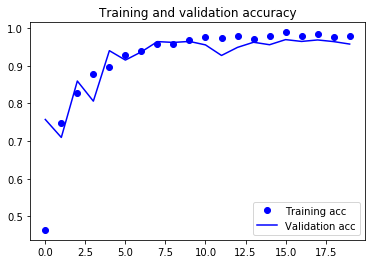

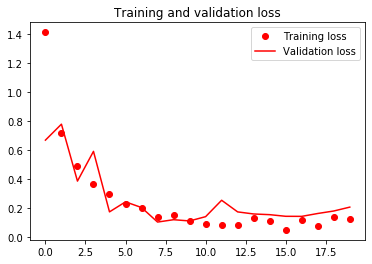

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from PIL import Image as Im # pip install Pillow (png파일 읽을 떄 전용함수)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Lena = Im.open('C:/Users/Affinity/Desktop/study/Module05/lena.jpg') # 이미지열기
Lena.size # 이미지 크리 출력 (40000나옴)
# Lena.show() # 이미지 보기
Lena = Lena.resize((200,200)) # 크기를 200x200 으로
Lena = Lena.convert('L') # 흑백화면으로
Lena = np.array(Lena, dtype = np.float32) # 행렬로
Lena = Lena.reshape(1, 200, 200, 1)
Lena.shape # [1,200,200,1]=[batch, ht, wdth, channel 수]
K1 = tf.constant([[[[-1.]],[[-1.]],[[-1.]]],[[[-1.]],[[9.]],[[-1.]]],[[[-1.]],[[-1.]],[[-1.]]]])
# K1 size = (3,3,1,1) = [ht, wdth, channel, 개수]
a1 = tf.nn.conv2d(Lena, K1, strides = [1,1,1,1], padding = 'VALID')

sess = tf.Session()
a1 = sess.run(a1)
a1.shape # = [1, 9=198, 198, 1] = [channel수, ht, wdth, batch]
a1_img = np.swapaxes(a1, 0, 3)
a1_img.shape # axis 0과 3을 서로 바꾸기 => [1, 198, 198, 1] = [batch,ht,wdth,channel수]

# 최대값 풀링(2)
h1 = tf.nn.max_pool(a1_img, ksize = [1,2,2,1],
                    strides = [1,2,2,1], padding = 'VALID')

h1 = sess.run(h1)
h1.shape # [1, 99, 99, 1]
plt.subplot(1,3,1)
plt.imshow(Lena.reshape(200, 200), cmap = 'Greys')
plt.subplot(1,3,2)
plt.imshow(a1_img.reshape(198,198), cmap = 'Greys')
plt.subplot(1,3,3)
plt.imshow(h1.reshape(99,99), cmap = 'Greys')

### 저장한 모델 로드하기

In [6]:
from keras.models import load_model

model_1 = load_model('fresh_and_rotten_1.h5')
model_1.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 36)      1008      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 36)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 72)        23400     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 72)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 72)        46728     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 72)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 288)       186912    
__________

다른 과일 사진 가져와서 predict 해보기

In [62]:

from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
testing_apple = test_datagen.flow_from_directory('C:/Users/Affinity/Documents/fresh_fruit_test', target_size=(150, 150))

Found 4 images belonging to 1 classes.


In [63]:
model_1.predict_generator(testing_apple, steps = 1).argmax(axis = 1)

array([1, 0, 0, 4], dtype=int64)

In [40]:
print(test_generator.class_indices)

{'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}


In [ ]:
img_path = 'C:/Users/Affinity/Documents/fresh_fruit_test/딱따구리/6.jpg'

# 이미지를 4D 텐서로 변경합니다.
from keras.preprocessing import image
import numpy as np

img = image.load_img

In [65]:

from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # 기억을 되살리기 위해서 모델 구조를 출력합니다

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [66]:
from keras import models

# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [69]:
activation_model